In [157]:
import pandas as pd
import numpy as np
import seaborn as sns
path = '/home/alvaro/Escritorio/FIUBA/Programación/Organizacion de datos'
df= pd.read_csv(path + '/train.csv')
dfUsosMultiples=df
#Fuente: https://es.investing.com/currencies/usd-mxn-historical-data
#AGREGAR EL PATH CORRESPONDIENTE
path1 = '/home/alvaro/Descargas'
dolar= pd.read_csv(path1 + '/Datos históricos USD_MXN.csv')
dolar.columns = ["fecha", "last", "opening", "max", "min", "std"]
dolar.drop(["std", "opening", "opening", "max", "min"], axis=1 ,inplace=True)
#Paso a formato fecha correctamente y luego creo columnas mes y año
dolar['date'] = pd.to_datetime(dolar['fecha'], format="%b %Y")
dolar.drop(["fecha"], axis=1, inplace=True)
dolar.columns= ['price', "date"]
#El csv ponia los numeros con punto en vez de coma.
dolar['price'] = dolar['price'].replace(',', '.', regex=True).astype(float)
dolar["year"] = dolar.date.dt.year
dolar['month'] = dolar.date.dt.month
dolar.drop(["date"], axis=1, inplace=True)
df['fecha'] = pd.to_datetime(df['fecha'])
df['year'] = df['fecha'].dt.year
df['month']= df['fecha'].dt.month
#Agrego la columna precio en dolar por propiedad, en el dataframe original
newDf= pd.merge(df, dolar, on=['year', 'month'], how='left')
newDf["dollar_price"] = newDf.apply(lambda row: row["precio"]/row["price"], axis=1)
#Filtro dejando las cosas útiles.
#Para agregar una columna, se debe agregar aca y luego agregarla al merge
df = newDf.filter(["id", "tipodepropiedad", "habitaciones",'garages', 'banos', 'ciudad',
                   'provincia','metroscubiertos', 'metrostotales', 'idzona', 'fecha',
                   'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas',
                   'centroscomercialescercanos', 'dollar_price' ])
def asignarMetros(metroscubiertos, metrostotales):
    if (metroscubiertos != 0 and metrostotales == 0):
        return metroscubiertos
    else:
        return metrostotales
    
#Arreglando, no pueden haber propiedades con metros cubiertos pero sin metros totales
df['metrostotales'].fillna(0, inplace=True)
df['metrostotales'] = df.apply(lambda x: asignarMetros(x['metroscubiertos'],x['metrostotales']),axis=1)
df.head()
#Filtrando el garage, lotes, hospedaje, otros
filtroTerreno = df["tipodepropiedad"].isin(["Huerta", "Nave industrial", "Terreno", "Terreno comercial", 
                                            "Bodega comercial", "Terreno industrial"])
dfTerreno = df[filtroTerreno]
dfTerreno.tipodepropiedad.value_counts()
#Dropeo todos los terrenos que tienen habitaciones ya que si las tienen no serian terrenos.
dfTerreno = dfTerreno[dfTerreno["habitaciones"].isna()]
dfTerreno.tipodepropiedad.value_counts()
#Limpiando las propiedades tipo casa, no pueden no tener al menos una habitacion o baño y no pueden
#tener metros no cubiertos
filtro1 = df["tipodepropiedad"].isin(["Apartamento", "Casa", "Casa en condominio", "Edificio"
                                        "Casa uso de suelo", "Rancho", "Quinta Vacacional"])
dfCasas = df[filtro1]
dfCasas = dfCasas[np.isfinite(dfCasas['habitaciones'])]
dfCasas = dfCasas[np.isfinite(dfCasas['banos'])]
dfCasas = dfCasas[np.isfinite(dfCasas['metroscubiertos'])]
dfCasas.garages.fillna(0, inplace=True)
df = pd.merge(dfCasas, dfTerreno, on=['id', 'tipodepropiedad', 'habitaciones', 'garages', 'banos', 'metroscubiertos'
                                      ,'ciudad','provincia','metrostotales','idzona','fecha', 'gimnasio','usosmultiples',
                                       'piscina','escuelascercanas','centroscomercialescercanos', 'dollar_price'], how='outer')

In [158]:
dfUsosMultiples

,id,titulo,descripcion,tipodepropiedad,direccion,ciudad,provincia,antiguedad,habitaciones,garages,...,lng,fecha,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,precio,year,month
0,254099,depto. tipo a-402,"depto. interior de 80.15m2, consta de sala com...",Apartamento,Avenida Division del Norte 2005,Benito Juárez,Distrito Federal,NaN,2.0,1.0,...,NaN,2015-08-23,0.0,0.0,0.0,0.0,0.0,2273000.0,2015,8
1,53461,condominio horizontal en venta,"<p>entre sonora y guerrero, atr&aacute;s del h...",Casa en condominio,AV. MEXICO,La Magdalena Contreras,Distrito Federal,10.0,3.0,2.0,...,-99.227655,2013-06-28,0.0,0.0,0.0,1.0,1.0,3600000.0,2013,6
2,247984,casa en venta urbi 3 recamaras tonala,descripcion \nla mejor ubicacion residencial e...,Casa,Urbi Tonala,Tonalá,Jalisco,5.0,3.0,2.0,...,NaN,2015-10-17,0.0,0.0,0.0,0.0,0.0,1200000.0,2015,10
3,209067,casa sola en toluca zinacantepec con credito i...,casa en privada con caseta de vigilancia casas...,Casa,IGNACIO MANUEL ALTAMIRANO 128,Zinacantepec,Edo. de México,1.0,2.0,1.0,...,-99.688015,2012-03-09,0.0,0.0,0.0,1.0,1.0,650000.0,2012,3
4,185997,paseos del sol,bonito departamento en excelentes condiciones ...,Apartamento,PASEOS DEL SOL,Zapopan,Jalisco,10.0,2.0,1.0,...,NaN,2016-06-07,0.0,0.0,0.0,0.0,0.0,1150000.0,2016,6
5,126147,departamento en venta taxqueña,"amplio departamento, estancia de sala y comedo...",Apartamento,Condominio Tlalpan 2B,Coyoacán,Distrito Federal,5.0,2.0,1.0,...,-99.148475,2014-03-18,0.0,0.0,0.0,0.0,1.0,1100000.0,2014,3
6,139233,de oportunidad casa en san lorenzo,"ubicada en esquina, pertenece san lorenzo agen...",Casa,NaN,Oaxaca de Juárez,Oaxaca,NaN,3.0,1.0,...,-96.803504,2016-02-23,0.0,0.0,0.0,0.0,0.0,1150000.0,2016,2
7,5013,casa emilia en venta en selvamar playa del carmen,casa emilia en venta playa del carmenfracciona...,Casa,condominio el trebol,Playa del Carmen,Quintana Roo,2.0,4.0,2.0,...,-87.037968,2016-10-20,0.0,0.0,0.0,0.0,0.0,4200000.0,2016,10
8,44962,pre- venta preciosos depas 2 recamaras con sub...,<p>pre-venta de preciosos departamento ecologi...,Apartamento,BUENAVISTA DEPTOS CON SUBSIDIO,Villa de Alvarez,Colima,1.0,2.0,1.0,...,NaN,2014-01-06,0.0,0.0,0.0,1.0,1.0,310000.0,2014,1
9,134537,terreno,"terreno de 5.500m2 bardeado, uso de suelo h-20...",Terreno,Av. Morelos,Ixtapaluca,Edo. de México,NaN,NaN,NaN,...,-98.887000,2016-12-22,0.0,0.0,0.0,0.0,0.0,6200000.0,2016,12


In [171]:
def cambiarNombre(word):
    if(word == 1.0):
        return "Con usos multiples"
    else:
        return "Sin usos multiples"

In [165]:
usosMultiples = dfasd["usosmultiples"].isin([1.0])
dfUM = dfUsosMultiples[usosMultiples]
group = dfUM.groupby("tipodepropiedad").agg({"tipodepropiedad":{"amount" : "count"}})
group.reset_index(inplace=True)
group.columns = ["tipodepropiedad", "amount"]
group = group[group["tipodepropiedad"].isin(["Apartamento", "Casa", "Casa en condominio"])]
group

,tipodepropiedad,amount
0,Apartamento,6187
1,Casa,5099
2,Casa en condominio,1907


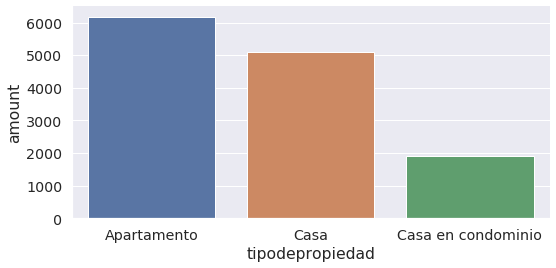

In [166]:
g = sns.catplot(x='tipodepropiedad', y='amount',
                kind="bar",  data=group, height=4,aspect=2)

/home/alvaro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


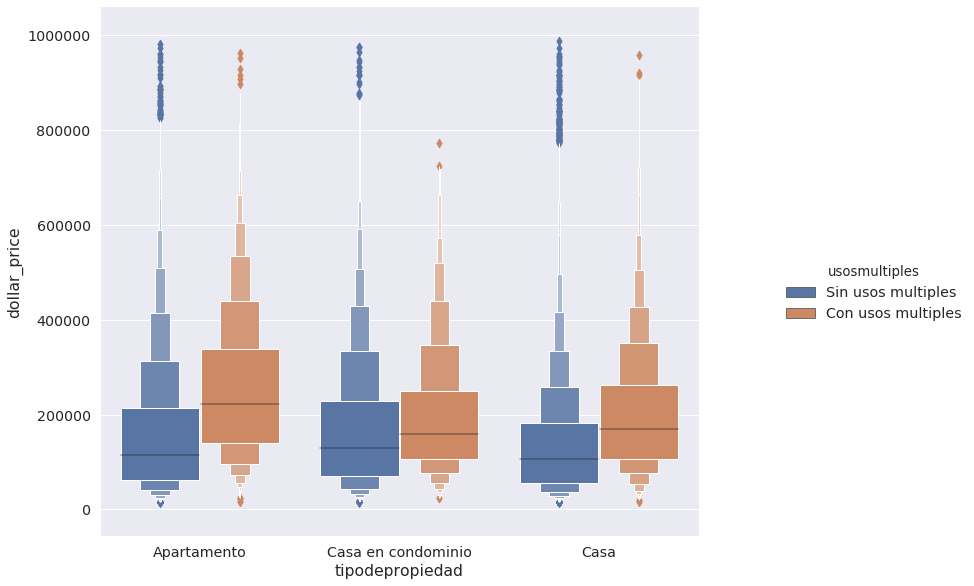

In [172]:
dfUM = df[df.tipodepropiedad.isin(["Apartamento", "Casa", "Casa en condominio"])]
dfUM["usosmultiples"] = dfUM.apply(lambda x: cambiarNombre(x['usosmultiples']),axis=1)
sns.set(font_scale=1.3)
g = sns.catplot(x='tipodepropiedad', y='dollar_price', hue = "usosmultiples",
                kind="boxen",  data=dfUM, height=4,aspect=2)
g.fig.set_size_inches(15,10)

/home/alvaro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [107]:
dfPools.piscinaWord.value_counts(normalize=True)

Sin piscina    0.908281
Con piscina    0.091719
Name: piscinaWord, dtype: float64